# Manufacturing Defect Recognition
## **BIA667 Final Project**

####**Team F**

####***Team Members:***

Kenneth Gan<br>
Vikrant Gajare<br>
Srivedh Chagantipati
<br><br>

***Business Objectives:***
 

*   To develop image recognition models to classify products as either "conforming" or "non-conforming" material
*   To compare models with respect to speed and overall performance

 

##Data Source
<br>
Data was manually captured using a 16MP Polaroid iS048 camera and corresponds to finished assemblies prepared for final packaging.  The products are scrapped medical devices that have been modified for use within the scope of this product; all product has been clearly labeled with "Not for Human Use" stickers and were captured at the OEM.  The samples fall into two major categories:


1.   Conforming - Units have all necessary accessories included within the kit
2.   Non-conforming - Units are missing one of the subassemblies from the kit



### Motivation
Human visual inspections have been noted to yield approximately 85% effectiveness when used in a production environment.  As a result, in order to ensure product quality ahead of packaging, sterilization, and shipment to the customer, 2x or 3x inspections are required (200% and 300% inspections, respectively).  This means that multiple employees are required to perform the same inspection during the course of a several hundred piece production lot.  With labor shortages due to COVID, there is a growing need to automate both the inspection and build processes for product.  The utility and accuracy of AI and Deep Learning techniques provide a means to alleviate these challenges and will certainly one day reshape the entire manufacturing industry. <br> <br>
This Final Project looks to explore these capabilities by comparing several different modeling techniques:

<ol>
<li>Baseline CNN</li>
<li>CNN with Data Augmentation</li>
<li>Pre-trained model</li>
</ol>
Each section will be briefly described as to its purpose in relation to achieving the overall business objectives.


###Dependencies


In [1]:
! pip install torchinfo

In [2]:
import os
import shutil
import glob
import random
import concurrent
import zipfile
import torch
import PIL
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split, Dataset
from IPython.display import Image
from torchinfo import summary
import torchvision
import time
import torchvision.models as models

In [3]:
# Connect to GPU; Google Colab PRO+ used for execution
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import os
from google.colab import drive

drive.mount('/content/drive') # mount the drive

Mounted at /content/drive


In [5]:
cwd = os.getcwd()
print(cwd)
os.chdir('/content/drive/MyDrive/BIA662_Final_Project_Data')

cwd = os.getcwd()

print(cwd)

/content
/content/drive/MyDrive/BIA662_Final_Project_Data


###Re-organize Data & Generate Conforming/Non-conforming Samples
This establishes directories for subsequent codes to function properly; this allows for accessing, labeling, and visualizing the images used within the dataset previously described.

In [6]:
# cwd
cwd = os.getcwd()

# define three directories for subsequent use
conforming_nonconforming_dir = os.path.join(cwd, 'Conforming_Nonconforming')
if not os.path.exists(conforming_nonconforming_dir):
    os.mkdir(conforming_nonconforming_dir)

conforming_dir = os.path.join(cwd, 'Conforming')
if not os.path.exists(conforming_dir):
    os.mkdir(conforming_dir)
    
nonconforming_dir = os.path.join(cwd, 'Nonconforming')
if not os.path.exists(nonconforming_dir):
    os.mkdir(nonconforming_dir)

# sample random 410 pics for conforming & non-conforming samples
conforming_pics = np.random.choice(glob.glob(os.path.join(cwd, 'Conforming', 'DSCF*')), size=410, replace=False)
nonconforming_pics = np.random.choice(glob.glob(os.path.join(cwd, 'Nonconforming', 'DSCF*')), size=410, replace=False)

# move to dir
def move_to_folder(scr_file, des_folder):
    des_name = os.path.basename(scr_file)
    shutil.copyfile(scr_file, os.path.join(des_folder, des_name))
# conforming
with concurrent.futures.ThreadPoolExecutor(max_workers=4) as pool:
    [pool.submit(move_to_folder, file_name, conforming_dir) for file_name in conforming_pics]
# non-conforming
with concurrent.futures.ThreadPoolExecutor(max_workers=4) as pool:
    [pool.submit(move_to_folder, file_name, nonconforming_dir) for file_name in nonconforming_pics]

In [7]:
# show a few of the file names within the directories
# note that the conforming_nonconforming directory has been renamed to allow
# for easier splitting in subsequent code
print(os.listdir(conforming_dir)[:10])
print("Length of Conforming Directory: "+ str(len(os.listdir(conforming_dir))))
print()
print(os.listdir(nonconforming_dir)[:10])
print("Length of Non-conforming Directory: "+ str(len(os.listdir(nonconforming_dir))))
print()
print(os.listdir(conforming_nonconforming_dir)[:10])
print("Length of Combined Directory: "+ str(len(os.listdir(conforming_nonconforming_dir))))

['DSCF0015.JPG', 'DSCF0016.JPG', 'DSCF0017.JPG', 'DSCF0018.JPG', 'DSCF0019.JPG', 'DSCF0020.JPG', 'DSCF0021.JPG', 'DSCF0022.JPG', 'DSCF0023.JPG', 'DSCF0025.JPG']
Length of Conforming Directory: 498

['DSCF0334.JPG', 'DSCF0335.JPG', 'DSCF0336.JPG', 'DSCF0337.JPG', 'DSCF0338.JPG', 'DSCF0339.JPG', 'DSCF0340.JPG', 'DSCF0341.JPG', 'DSCF0342.JPG', 'DSCF0343.JPG']
Length of Non-conforming Directory: 412

['con (27).JPG', 'con (28).JPG', 'con (29).JPG', 'con (30).JPG', 'con (31).JPG', 'con (32).JPG', 'con (33).JPG', 'con (34).JPG', 'con (35).JPG', 'con (37).JPG']
Length of Combined Directory: 910


###Show example of Conforming and Nonconforming samples
This provides an example of each type of sample with two different types of nonconformances shown, for reference.

DSCF0015.JPG
DSCF0020.JPG
DSCF0026.JPG
DSCF0031.JPG


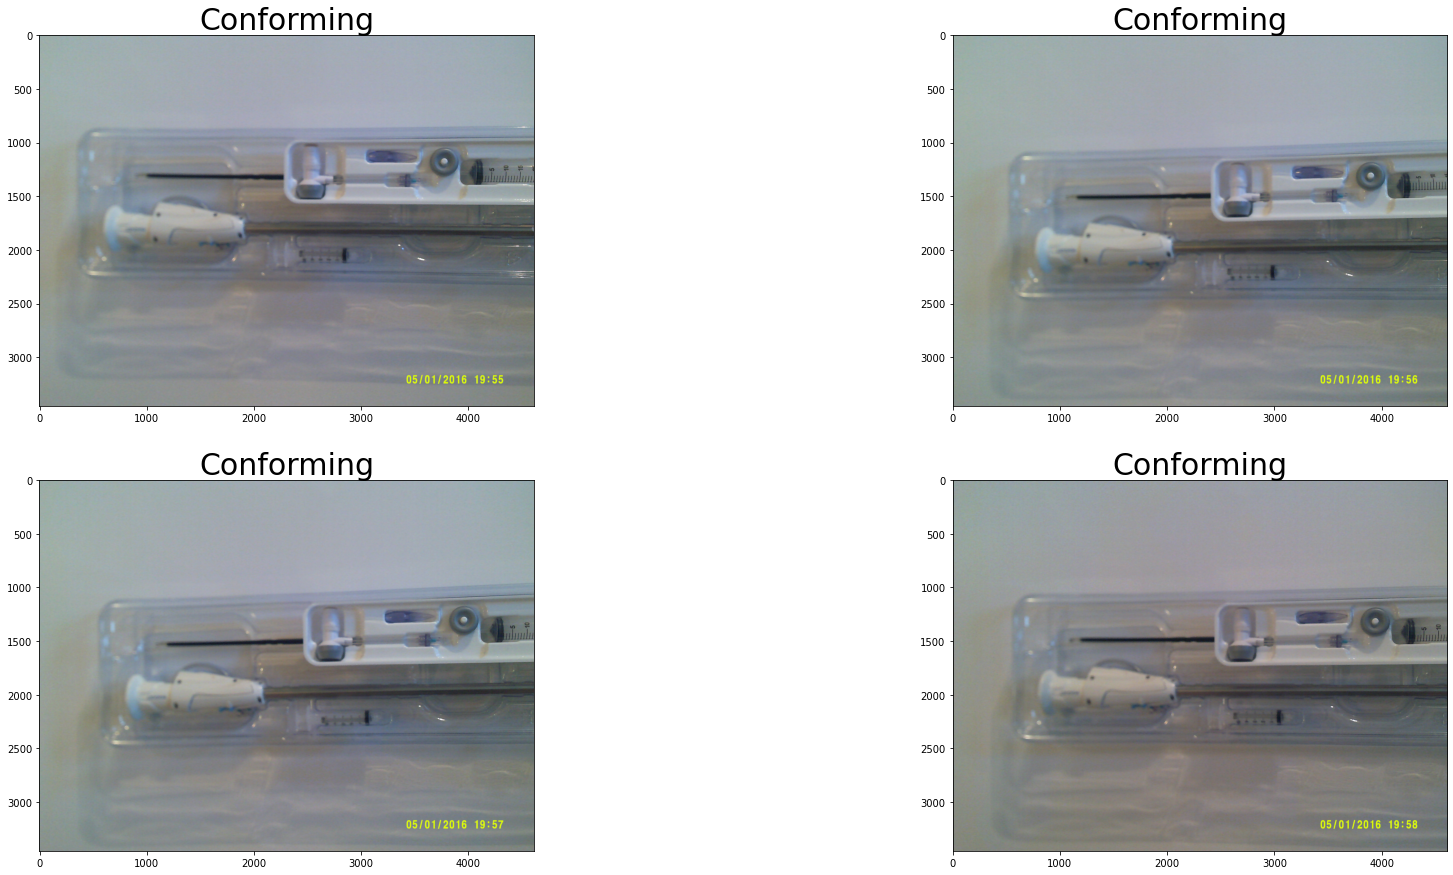

In [8]:
plt.figure(figsize=(30, 15))

for i in range(4):
    print(os.listdir(conforming_dir)[i*5])
    plt.subplot(2, 2, i + 1)
    conforming_img = plt.imread(os.path.join(conforming_dir, os.listdir(conforming_dir)[i*5]))
    plt.imshow(conforming_img)
    plt.title('Conforming', fontdict={'fontsize': 30})

DSCF0334.JPG
DSCF0339.JPG
DSCF0344.JPG
DSCF0349.JPG


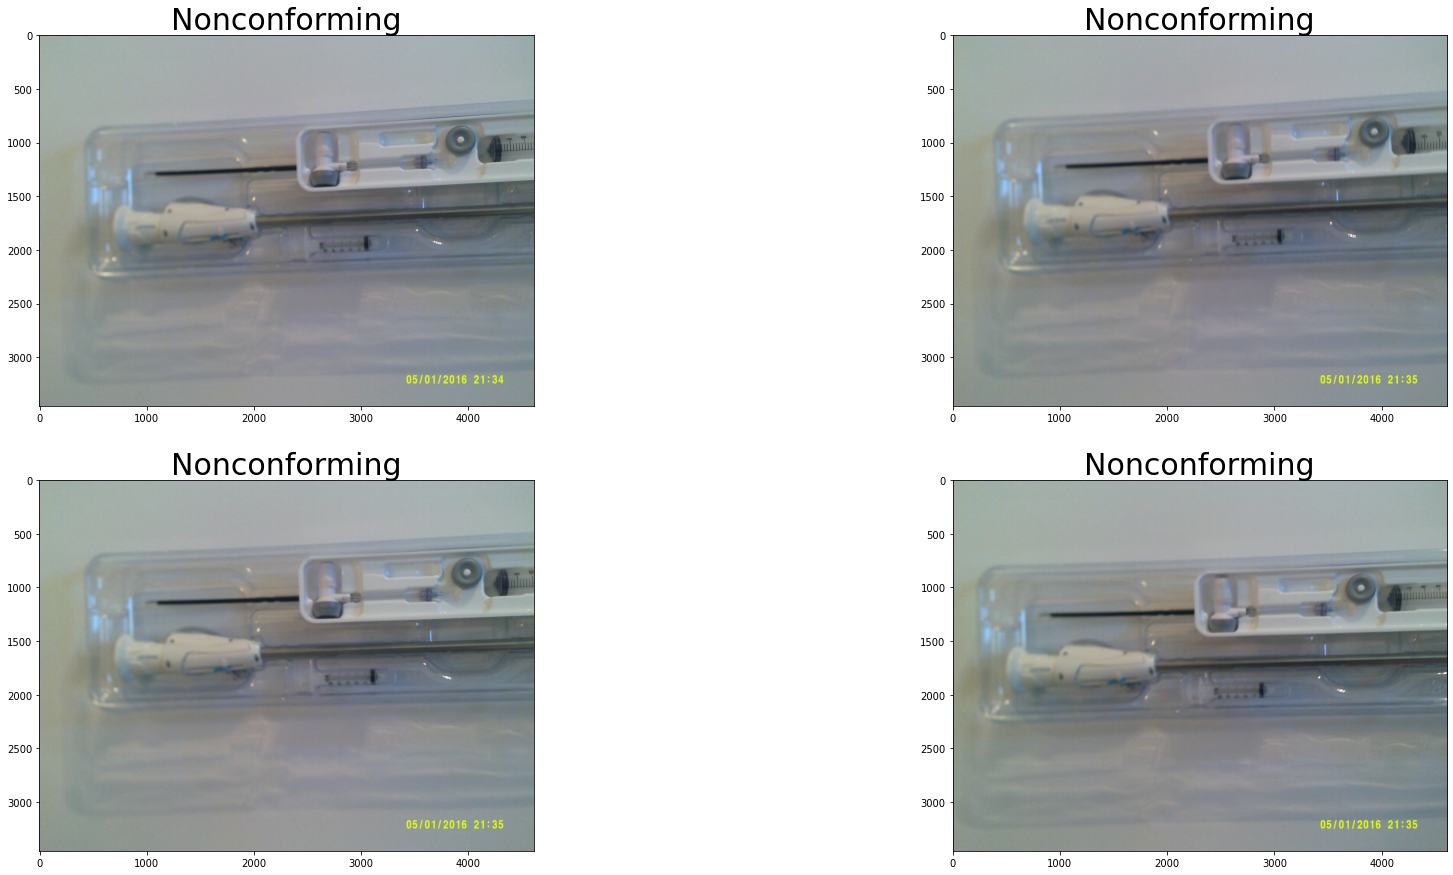

In [9]:
plt.figure(figsize=(30, 15))

for i in range(4):
    print(os.listdir(nonconforming_dir)[i*5])
    plt.subplot(2, 2, i + 1)
    nonconforming_img = plt.imread(os.path.join(nonconforming_dir, os.listdir(nonconforming_dir)[i*5]))
    plt.imshow(nonconforming_img)
    plt.title('Nonconforming', fontdict={'fontsize': 30})

##Define Baseline CNN Model
Convoluted Neural Network Model with multiple layers, which flattens the CNN output for classification within the linear classifier

In [10]:
class CNN_Classifier(nn.Module):
    def __init__(self):
        super(CNN_Classifier, self).__init__()
        # Conv net
        self.convnet = nn.Sequential(
            # input(3, 150, 150)
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3), # (32, 148, 148)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # (32, 74, 74)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),  # (64, 72, 72)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # (64, 36, 36)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),  # (128, 34, 34)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # (128, 17, 17)
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),  # (128, 15, 15)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # (128, 7, 7)
            nn.Flatten() # 6272 = 128 * 7 * 7
        )
        # classifier
        self.classifier = nn.Sequential(
            nn.Linear(in_features=6272, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=1)
        )
    
    def forward(self, x):
        x = self.convnet(x)
        x = self.classifier(x)

        return x

In [11]:
sample_model = CNN_Classifier()
summary(sample_model, (64, 3, 150, 150))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_Classifier                           --                        --
├─Sequential: 1-1                        [64, 6272]                --
│    └─Conv2d: 2-1                       [64, 32, 148, 148]        896
│    └─ReLU: 2-2                         [64, 32, 148, 148]        --
│    └─MaxPool2d: 2-3                    [64, 32, 74, 74]          --
│    └─Conv2d: 2-4                       [64, 64, 72, 72]          18,496
│    └─ReLU: 2-5                         [64, 64, 72, 72]          --
│    └─MaxPool2d: 2-6                    [64, 64, 36, 36]          --
│    └─Conv2d: 2-7                       [64, 128, 34, 34]         73,856
│    └─ReLU: 2-8                         [64, 128, 34, 34]         --
│    └─MaxPool2d: 2-9                    [64, 128, 17, 17]         --
│    └─Conv2d: 2-10                      [64, 128, 15, 15]         147,584
│    └─ReLU: 2-11                        [64, 128, 15, 15]         --
│

###Dataset Definition
Defines the dataset and labels the samples in joint directory.

In [12]:
class ImgDataset(Dataset):
    def __init__(self, img_path, img_labels, img_transforms=None):
        self.img_path = img_path
        self.img_labels = torch.Tensor(img_labels)
        if img_transforms is None:
            self.transforms = transforms.ToTensor()
        else:
            self.transforms = img_transforms
    
    def __getitem__(self, index):
        # load image
        cur_path = self.img_path[index]
        cur_img = PIL.Image.open(cur_path)
        cur_img = self.transforms(cur_img)

        return cur_img, self.img_labels[index]
    
    def __len__(self):
        return len(self.img_path)

In [13]:
images_list = glob.glob(os.path.join(conforming_nonconforming_dir, '*'))
# label: 0 for conforming samples, 1 for non-conforming
def extract_class(img_path):
    base_path = os.path.basename(img_path)
    return base_path.split(' ')[0]

labels = [0 if extract_class(cur_path) == 'con' else 1 for cur_path in images_list]

In [14]:
# Resize the inputs to increase speed and interpretation by the model
resize_transforms = transforms.Compose([transforms.Resize((150, 150)), transforms.ToTensor()])

In [15]:
# Establish dataset to be used for train/validation/test splits
conforming_nonconforming_dataset = ImgDataset(img_path=images_list, img_labels=labels, img_transforms=resize_transforms)

In [16]:
conforming_nonconforming_dataset[0]

(tensor([[[0.6039, 0.6118, 0.6118,  ..., 0.5725, 0.5804, 0.5765],
          [0.6078, 0.6157, 0.6157,  ..., 0.5765, 0.5804, 0.5804],
          [0.6157, 0.6157, 0.6235,  ..., 0.5765, 0.5882, 0.5843],
          ...,
          [0.5373, 0.5373, 0.5412,  ..., 0.4980, 0.4941, 0.5059],
          [0.5294, 0.5333, 0.5333,  ..., 0.5020, 0.4980, 0.4980],
          [0.5333, 0.5412, 0.5373,  ..., 0.4980, 0.5020, 0.5059]],
 
         [[0.6784, 0.6745, 0.6784,  ..., 0.6549, 0.6549, 0.6471],
          [0.6784, 0.6784, 0.6824,  ..., 0.6588, 0.6549, 0.6510],
          [0.6784, 0.6824, 0.6824,  ..., 0.6627, 0.6549, 0.6471],
          ...,
          [0.5686, 0.5686, 0.5686,  ..., 0.5216, 0.5216, 0.5176],
          [0.5647, 0.5608, 0.5647,  ..., 0.5216, 0.5216, 0.5216],
          [0.5647, 0.5608, 0.5647,  ..., 0.5216, 0.5176, 0.5176]],
 
         [[0.6667, 0.6667, 0.6667,  ..., 0.6745, 0.6745, 0.6745],
          [0.6745, 0.6667, 0.6627,  ..., 0.6706, 0.6706, 0.6706],
          [0.6627, 0.6706, 0.6667,  ...,

In [17]:
print("Example of the tensor used to represent a sample (including label):")
print()
print(conforming_nonconforming_dataset[0])
print()
print()
print("Size of the image tensor:")
conforming_nonconforming_dataset[0][0].size()

Example of the tensor used to represent a sample (including label):

(tensor([[[0.6039, 0.6118, 0.6118,  ..., 0.5725, 0.5804, 0.5765],
         [0.6078, 0.6157, 0.6157,  ..., 0.5765, 0.5804, 0.5804],
         [0.6157, 0.6157, 0.6235,  ..., 0.5765, 0.5882, 0.5843],
         ...,
         [0.5373, 0.5373, 0.5412,  ..., 0.4980, 0.4941, 0.5059],
         [0.5294, 0.5333, 0.5333,  ..., 0.5020, 0.4980, 0.4980],
         [0.5333, 0.5412, 0.5373,  ..., 0.4980, 0.5020, 0.5059]],

        [[0.6784, 0.6745, 0.6784,  ..., 0.6549, 0.6549, 0.6471],
         [0.6784, 0.6784, 0.6824,  ..., 0.6588, 0.6549, 0.6510],
         [0.6784, 0.6824, 0.6824,  ..., 0.6627, 0.6549, 0.6471],
         ...,
         [0.5686, 0.5686, 0.5686,  ..., 0.5216, 0.5216, 0.5176],
         [0.5647, 0.5608, 0.5647,  ..., 0.5216, 0.5216, 0.5216],
         [0.5647, 0.5608, 0.5647,  ..., 0.5216, 0.5176, 0.5176]],

        [[0.6667, 0.6667, 0.6667,  ..., 0.6745, 0.6745, 0.6745],
         [0.6745, 0.6667, 0.6627,  ..., 0.6706, 0.670

torch.Size([3, 150, 150])

###Split the Dataset
Splits the data into the following sample groups:


*   Training Samples (60% of total)
*   Validation Samples (20% of total)
*   Testing Samples (20% of total)



In [18]:
split_size = (np.array([0.6, 0.2, 0.2]) * int(len(conforming_nonconforming_dataset))).round().astype(int)
train_data, valid_data, test_data = random_split(conforming_nonconforming_dataset, split_size)

In [19]:
train_data[1]

(tensor([[[0.6235, 0.6392, 0.6392,  ..., 0.6078, 0.6000, 0.6000],
          [0.6353, 0.6353, 0.6392,  ..., 0.6078, 0.6118, 0.6039],
          [0.6275, 0.6353, 0.6353,  ..., 0.6078, 0.6078, 0.6039],
          ...,
          [0.5412, 0.5529, 0.5529,  ..., 0.5059, 0.5020, 0.5059],
          [0.5490, 0.5490, 0.5451,  ..., 0.5059, 0.5059, 0.5059],
          [0.5529, 0.5490, 0.5451,  ..., 0.4980, 0.4980, 0.5020]],
 
         [[0.6863, 0.6863, 0.6902,  ..., 0.6745, 0.6745, 0.6706],
          [0.6863, 0.6902, 0.6902,  ..., 0.6784, 0.6745, 0.6706],
          [0.6902, 0.6941, 0.6902,  ..., 0.6784, 0.6745, 0.6745],
          ...,
          [0.5804, 0.5725, 0.5804,  ..., 0.5451, 0.5490, 0.5412],
          [0.5765, 0.5725, 0.5804,  ..., 0.5451, 0.5412, 0.5412],
          [0.5765, 0.5765, 0.5725,  ..., 0.5529, 0.5451, 0.5451]],
 
         [[0.6784, 0.6706, 0.6627,  ..., 0.6902, 0.6902, 0.6863],
          [0.6706, 0.6745, 0.6706,  ..., 0.6784, 0.6784, 0.6824],
          [0.6627, 0.6667, 0.6588,  ...,

In [20]:
train_labels = []
val_labels = []
test_labels = []
for x, y in train_data:
  train_labels.append(y.item())
for x, y in valid_data:
  val_labels.append(y.item())
for x, y in test_data:
  test_labels.append(y.item())

In [21]:
nonconforming_train = np.sum(train_labels)
nonconforming_val = np.sum(val_labels)
nonconforming_test = np.sum(test_labels)
conforming_train = len(train_labels) - nonconforming_train
conforming_val = len(val_labels) - nonconforming_val
conforming_test = len(test_labels) - nonconforming_test

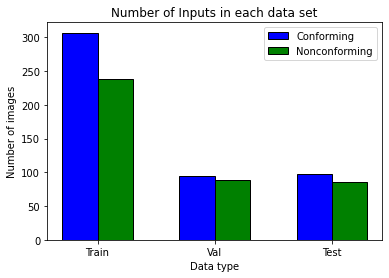

In [22]:
X = ['Train','Val','Test']
Conforming = [conforming_train,conforming_val,conforming_test]
Nonconforming = [nonconforming_train,nonconforming_val,nonconforming_test]

r = np.arange(3)
 
plt.bar(r, Conforming, color = 'b',
        width = 0.3, edgecolor = 'black',
        label='Conforming')
plt.bar(r + 0.3, Nonconforming, color = 'g',
        width = 0.3, edgecolor = 'black',
        label='Nonconforming')
  
plt.xlabel("Data type")
plt.ylabel("Number of images")
plt.title("Number of Inputs in each data set")
  
plt.xticks(r + 0.3/2,['Train','Val','Test'])
plt.legend()

plt.show()

###Train the Model
This section defines the function used to train the CNN model; it outputs a dictionary that stores the historical results for each of the epochs to be plotted for analysis and comparison.

In [23]:
print("Length of train data: " + str(len(train_data)))
print("Length of validation data: " + str(len(valid_data)))
print("Length of testing data: " + str(len(test_data)))
print()
print("Length of conforming training data: " + str(int(conforming_train)))
print("Length of nonconforming training data: " + str(int(nonconforming_train)))
print("Length of conforming validation data: " + str(int(conforming_val)))
print("Length of nonconforming training data: " + str(int(nonconforming_val)))
print("Length of conforming test data: " + str(int(conforming_test)))
print("Length of nonconforming test data: " + str(int(nonconforming_test)))

Length of train data: 546
Length of validation data: 182
Length of testing data: 182

Length of conforming training data: 307
Length of nonconforming training data: 239
Length of conforming validation data: 94
Length of nonconforming training data: 88
Length of conforming test data: 97
Length of nonconforming test data: 85


In [31]:
def train_model(model, train_dataset, valid_dataset, test_dataset, device, 
                lr=0.0001, epochs=30, batch_size=256):
    start_time = time.time()

    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    # move model to device
    model = model.to(device)

    # history
    history = {'train_loss': [],
               'train_acc': [],
               'val_loss': [],
               'val_acc': []}
    max_acc = -np.Inf
    # setup loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    # training loop
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        for x, y in train_loader:
            # move data to device
            x = x.to(device)
            y = y.to(device)
            # forward
            outputs = model(x).view(-1)  # (num_batch)
            cur_train_loss = criterion(outputs, y)
            pred = torch.sigmoid(outputs)
            pred = torch.round(pred)
            cur_train_acc = (pred == y).sum().item() / batch_size
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # loss and acc
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # test start
        model.eval()
        with torch.no_grad():
            for x, y in val_loader:
                # move
                x = x.to(device)
                y = y.to(device)
                # predict
                outputs = model(x).view(-1)
                pred = torch.round(torch.sigmoid(outputs))
                cur_val_loss = criterion(outputs, y)
                cur_val_acc = (pred == y).sum().item() / batch_size 
                # loss and acc
                val_loss += cur_val_loss
                val_acc += cur_val_acc

        # epoch output
        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        val_loss = (val_loss/len(val_loader)).item()
        val_acc = val_acc/len(val_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.4f} train_acc:{train_acc:.4f}, valid loss:{val_loss:.4f} valid acc:{val_acc:.4f}")
        
        if val_acc > max_acc:
            max_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print("model saved!")

    model.load_state_dict(torch.load("best_model.pth"))
    print("--- %s seconds ---" % (time.time() - start_time))
    
    
    test_acc = 0
    preds = []
    ys = []

    model.eval()
    ys = []
    preds = []

    with torch.no_grad():
        for x, y in test_loader:
            # move
            x = x.to(device)
            # predict
            outputs = model(x).view(-1)
            pred = torch.round(torch.sigmoid(outputs))

            preds.append(pred.view(-1).cpu().numpy())
            ys.append(y)

    ys = np.concatenate(ys)
    preds = np.concatenate(preds)

    test_acc = (ys==preds).astype(int).sum()/len(ys)
    print(f"test acc:{test_acc:.3f}")
    return test_acc, history

###Train Model
These next two cells perform the model training to be used in the evaluation of the testing sample set.  We will use a pre-established number of epochs; however, early stopping will be later employed to improve run times and overall performance in terms of testing accuracy.

In [32]:
cnn_model = CNN_Classifier()

In [33]:
test_acc_baseline, history_baseline = train_model(cnn_model, train_data, valid_data, test_data, device, batch_size=32, epochs=50, lr=0.0005)

Training Start
Epoch:1 / 50, train loss:0.8868 train_acc:0.5017, valid loss:0.7013 valid acc:0.4896
model saved!
Epoch:2 / 50, train loss:0.6898 train_acc:0.5330, valid loss:0.6959 valid acc:0.4896
Epoch:3 / 50, train loss:0.6818 train_acc:0.5330, valid loss:0.7120 valid acc:0.4896
Epoch:4 / 50, train loss:0.6866 train_acc:0.5330, valid loss:0.6950 valid acc:0.4896
Epoch:5 / 50, train loss:0.6880 train_acc:0.5330, valid loss:0.6940 valid acc:0.4896
Epoch:6 / 50, train loss:0.6869 train_acc:0.5330, valid loss:0.6983 valid acc:0.4896
Epoch:7 / 50, train loss:0.6859 train_acc:0.5330, valid loss:0.6924 valid acc:0.4896
Epoch:8 / 50, train loss:0.6741 train_acc:0.5330, valid loss:1.6120 valid acc:0.4896
Epoch:9 / 50, train loss:0.7352 train_acc:0.5330, valid loss:0.6897 valid acc:0.4896
Epoch:10 / 50, train loss:0.6824 train_acc:0.5295, valid loss:0.6967 valid acc:0.4583
Epoch:11 / 50, train loss:0.6970 train_acc:0.5347, valid loss:0.6882 valid acc:0.6458
model saved!
Epoch:12 / 50, train l

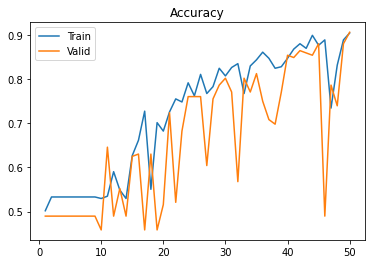

In [34]:
plt.plot(range(1, 51), history_baseline['train_acc'], label='Train')
plt.plot(range(1, 51), history_baseline['val_acc'], label='Valid')
plt.title('Accuracy')
plt.legend()
plt.show()

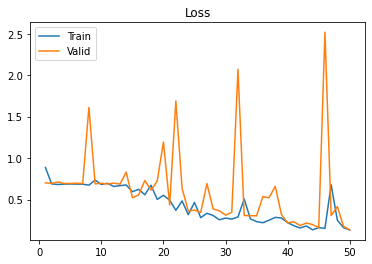

In [35]:
plt.plot(range(1, 51), history_baseline['train_loss'], label='Train')
plt.plot(range(1, 51), history_baseline['val_loss'], label='Valid')
plt.title('Loss')
plt.legend()
plt.show()

In [36]:
accuracy_percent = test_acc_baseline*100
print("BASELINE CNN TEST ACCURACY:")
print(str(round(accuracy_percent,2)))

BASELINE CNN TEST ACCURACY:
95.6


###Data Augmentation with CNN Model
Data augmentation allows the training function to visualize the images in an alternative manner.  This can help to highlight certain features that can aid in the classification process.  If performed properly, this can improve test accuracies.<br><br>
###Provide Sample Images from each Class with Augmentations

DSCF0334.JPG


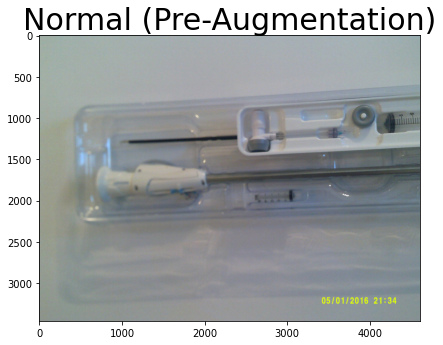

In [ ]:
plt.figure(figsize=(15, 15))

for i in range(1):
    print(os.listdir(nonconforming_dir)[i])
    plt.subplot(2, 2, i + 1)
    nonconforming_img = plt.imread(os.path.join(nonconforming_dir, os.listdir(nonconforming_dir)[i*5]))
    plt.imshow(nonconforming_img)
    plt.title("Normal (Pre-Augmentation)", fontdict={"fontsize": 30})

Text(0.5, 1.0, 'Augmented')

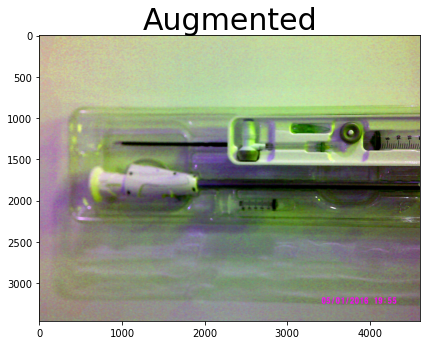

In [ ]:
sample_img_path = os.path.join(conforming_dir, os.listdir(conforming_dir)[0])
sample_img_aug = PIL.Image.open(sample_img_path)

# apply random color jitter
transformed_img = transforms.ColorJitter(brightness=0.2, contrast=0.9, saturation=0.8, hue=0.5)(sample_img_aug)
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
#nonconforming_img_aug = plt.imread(os.path.join(conforming_dir, os.listdir(conforming_dir)[0]))
plt.imshow(transformed_img)
plt.title("Augmented", fontdict={"fontsize": 30})

Text(0.5, 1.0, 'Augmented')

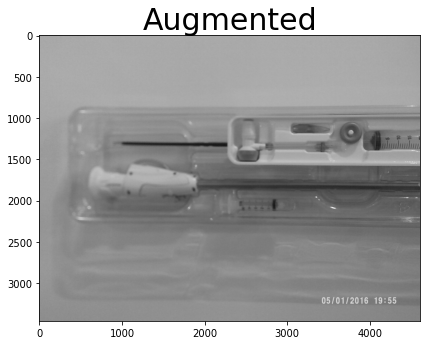

In [ ]:
sample_img_path = os.path.join(conforming_dir, os.listdir(conforming_dir)[0])
sample_img_gray = PIL.Image.open(sample_img_path)

# apply grayscale
transformed_img_gray = transforms.RandomGrayscale(p=1.0)(sample_img_gray)
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
#nonconforming_img_aug = plt.imread(os.path.join(conforming_dir, os.listdir(conforming_dir)[0]))
plt.imshow(transformed_img_gray)
plt.title('Augmented', fontdict={'fontsize': 30})

###Prepare Transform Pipeline for Assessment
Before settling on the final transformations to apply, a transformation pipeline was established and tuned until the final, isolated techniques were used.  Although a complicated transform has utility in certain applications, it was non-beneficial here, and it decreased overall performance of the model.

In [37]:
class ImgDataset(Dataset):
    def __init__(self, img_path, img_labels, img_transforms=None):
        self.img_path = img_path
        self.img_labels = torch.Tensor(img_labels)
        if img_transforms is None:
            self.transforms = transforms.ToTensor()
        else:
            self.transforms = img_transforms
    
    def __getitem__(self, index):
        # load image
        cur_path = self.img_path[index]
        cur_img = PIL.Image.open(cur_path)
        cur_img = self.transforms(cur_img)

        return cur_img, self.img_labels[index]
    
    def __len__(self):
        return len(self.img_path)

In [38]:
transformations = transforms.Compose([transforms.Resize((150, 150)),  # resize to input shape of our CNN
                                      #transforms.ColorJitter(brightness=0.2, contrast=0.9, saturation=0.8, hue=0.4),
                                      transforms.RandomGrayscale(p=1.0),
                                      #transforms.RandomRotation(40),
                                      #transforms.RandomAffine(degrees=0, scale=(0.8, 1.2), shear=0.2),
                                      #transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor()  # convert PIL to Tensor
                                      ])

In [39]:
conforming_nonconforming_dataset_transformed = ImgDataset(img_path=images_list, img_labels=labels, img_transforms=transformations)

In [40]:
split_size = (np.array([0.6, 0.2, 0.2]) * int(len(conforming_nonconforming_dataset_transformed))).round().astype(int)
train_data_trans, valid_data_trans, test_data_trans = random_split(conforming_nonconforming_dataset_transformed, split_size)

###Split the Data and Visualize Sample Classes
Data is split into conforming and non-conforming classes.  Each of the sample groups (train, validation, test) were visualized to observe sufficient presence of each class within the groups

In [41]:
train_labels = []
val_labels = []
test_labels = []
for x, y in train_data_trans:
  train_labels.append(y.item())
for x, y in valid_data_trans:
  val_labels.append(y.item())
for x, y in test_data_trans:
  test_labels.append(y.item())

In [42]:
nonconforming_train_trans = np.sum(train_labels)
nonconforming_val_trans = np.sum(val_labels)
nonconforming_test_trans = np.sum(test_labels)
conforming_train_trans = len(train_labels) - nonconforming_train_trans
conforming_val_trans = len(val_labels) - nonconforming_val_trans
conforming_test_trans = len(test_labels) - nonconforming_test_trans

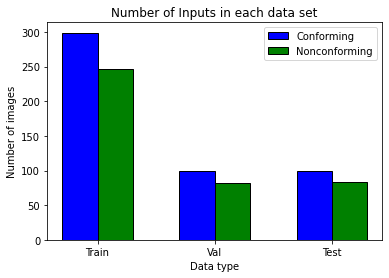

In [43]:
X = ['Train','Val','Test']
Conforming_Aug = [conforming_train_trans,conforming_val_trans,conforming_test_trans]
Nonconforming_Aug = [nonconforming_train_trans,nonconforming_val_trans,nonconforming_test_trans]

r = np.arange(3)
 
plt.bar(r, Conforming_Aug, color = 'b',
        width = 0.3, edgecolor = 'black',
        label='Conforming')
plt.bar(r + 0.3, Nonconforming_Aug, color = 'g',
        width = 0.3, edgecolor = 'black',
        label='Nonconforming')
  
plt.xlabel("Data type")
plt.ylabel("Number of images")
plt.title("Number of Inputs in each data set")
  
plt.xticks(r + 0.3/2,['Train','Val','Test'])
plt.legend()

plt.show()

In [44]:
print("Length of train data: " + str(len(train_data_trans)))
print("Length of validation data: " + str(len(valid_data_trans)))
print("Length of testing data: " + str(len(test_data_trans)))
print()
print("Length of conforming training data: " + str(int(conforming_train_trans)))
print("Length of nonconforming training data: " + str(int(nonconforming_train_trans)))
print("Length of conforming validation data: " + str(int(conforming_val_trans)))
print("Length of nonconforming training data: " + str(int(nonconforming_val_trans)))
print("Length of conforming test data: " + str(int(conforming_test_trans)))
print("Length of nonconforming test data: " + str(int(nonconforming_test_trans)))

Length of train data: 546
Length of validation data: 182
Length of testing data: 182

Length of conforming training data: 299
Length of nonconforming training data: 247
Length of conforming validation data: 100
Length of nonconforming training data: 82
Length of conforming test data: 99
Length of nonconforming test data: 83


In [ ]:
# Display a sample of the transformed data along with its size

In [46]:
print(conforming_nonconforming_dataset_transformed[0])
conforming_nonconforming_dataset_transformed[0][0].size()

(tensor([[[0.6549, 0.6549, 0.6588,  ..., 0.6314, 0.6353, 0.6275],
         [0.6588, 0.6588, 0.6588,  ..., 0.6353, 0.6353, 0.6314],
         [0.6588, 0.6627, 0.6627,  ..., 0.6392, 0.6353, 0.6314],
         ...,
         [0.5569, 0.5569, 0.5569,  ..., 0.5098, 0.5098, 0.5098],
         [0.5529, 0.5529, 0.5529,  ..., 0.5098, 0.5098, 0.5098],
         [0.5529, 0.5529, 0.5529,  ..., 0.5098, 0.5098, 0.5098]],

        [[0.6549, 0.6549, 0.6588,  ..., 0.6314, 0.6353, 0.6275],
         [0.6588, 0.6588, 0.6588,  ..., 0.6353, 0.6353, 0.6314],
         [0.6588, 0.6627, 0.6627,  ..., 0.6392, 0.6353, 0.6314],
         ...,
         [0.5569, 0.5569, 0.5569,  ..., 0.5098, 0.5098, 0.5098],
         [0.5529, 0.5529, 0.5529,  ..., 0.5098, 0.5098, 0.5098],
         [0.5529, 0.5529, 0.5529,  ..., 0.5098, 0.5098, 0.5098]],

        [[0.6549, 0.6549, 0.6588,  ..., 0.6314, 0.6353, 0.6275],
         [0.6588, 0.6588, 0.6588,  ..., 0.6353, 0.6353, 0.6314],
         [0.6588, 0.6627, 0.6627,  ..., 0.6392, 0.6353, 0

torch.Size([3, 150, 150])

In [47]:
cnn_model = CNN_Classifier()

###Train Augmented CNN Model

In [48]:
test_acc_aug, history_augmented = train_model(cnn_model, train_data_trans, valid_data_trans, test_data_trans, device, batch_size=16, epochs=50, lr=0.0005)

Training Start
Epoch:1 / 50, train loss:0.7643 train_acc:0.5446, valid loss:0.6900 valid acc:0.5208
model saved!
Epoch:2 / 50, train loss:0.6877 train_acc:0.5339, valid loss:0.6937 valid acc:0.5208
Epoch:3 / 50, train loss:0.6910 train_acc:0.5339, valid loss:0.6887 valid acc:0.5208
Epoch:4 / 50, train loss:0.6895 train_acc:0.5339, valid loss:0.6888 valid acc:0.5208
Epoch:5 / 50, train loss:0.6914 train_acc:0.5339, valid loss:0.6887 valid acc:0.5208
Epoch:6 / 50, train loss:0.6905 train_acc:0.5339, valid loss:0.6888 valid acc:0.5208
Epoch:7 / 50, train loss:0.6879 train_acc:0.5339, valid loss:0.6892 valid acc:0.5208
Epoch:8 / 50, train loss:0.6926 train_acc:0.5339, valid loss:0.6896 valid acc:0.5208
Epoch:9 / 50, train loss:0.6918 train_acc:0.5339, valid loss:0.6898 valid acc:0.5208
Epoch:10 / 50, train loss:0.6900 train_acc:0.5339, valid loss:0.6892 valid acc:0.5208
Epoch:11 / 50, train loss:0.6895 train_acc:0.5339, valid loss:0.6887 valid acc:0.5208
Epoch:12 / 50, train loss:0.6904 tr

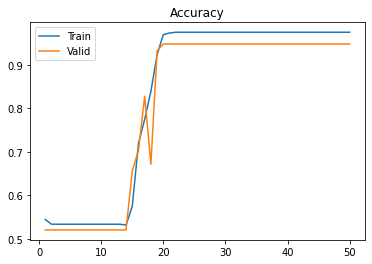

In [49]:
plt.plot(range(1, 51), history_augmented['train_acc'], label='Train')
plt.plot(range(1, 51), history_augmented['val_acc'], label='Valid')
plt.title('Accuracy')
plt.legend()
plt.show()

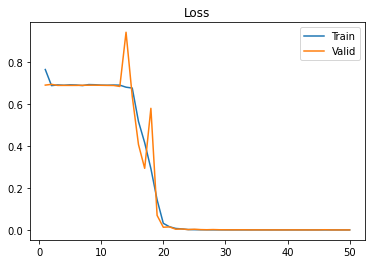

In [50]:
plt.plot(range(1, 51), history_augmented['train_loss'], label='Train')
plt.plot(range(1, 51), history_augmented['val_loss'], label='Valid')
plt.title('Loss')
plt.legend()
plt.show()

In [51]:
accuracy_percent = test_acc_aug*100
print("BASELINE CNN TEST ACCURACY:")
print(str(round(accuracy_percent,2)))

BASELINE CNN TEST ACCURACY:
99.45


###VGG-16 Model with all Layers Frozen
The use of this pre-trained model is explained extensively within the report; however, it is a robust CNN with 16 layers and proven to excel in classification of an array of image recognition use-cases.  The model can be readily implemented, so it is not complicated from a coding perspective, but it can be modified through the application of user-defined layers.  This helps preserve the versatility of the original model, while tailoring it for a particular set of images.

In [52]:
VGG_model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [53]:
for name, param in VGG_model.named_parameters():
  param.requires_grad = False

In [54]:
binary_classifier = nn.Sequential(
   nn.Linear(in_features=25088, out_features=2048),
   nn.ReLU(),
   nn.Linear(in_features=2048, out_features=1024),
   nn.ReLU(),
   nn.Linear(in_features=1024, out_features=512),
   nn.ReLU(),
   nn.Linear(in_features=512, out_features=1)
)

# replace model class classifier attribute:
VGG_model.classifier = binary_classifier

###Train VGG-16 Model

In [55]:
test_acc_VGG, history_VGG = train_model(VGG_model, train_data, valid_data, test_data, device, batch_size=32, epochs=30, lr=0.00001)

Training Start
Epoch:1 / 30, train loss:0.6145 train_acc:0.6354, valid loss:0.6777 valid acc:0.4896
model saved!
Epoch:2 / 30, train loss:0.4454 train_acc:0.8212, valid loss:0.6100 valid acc:0.5781
model saved!
Epoch:3 / 30, train loss:0.3234 train_acc:0.8715, valid loss:0.3069 valid acc:0.8542
model saved!
Epoch:4 / 30, train loss:0.2352 train_acc:0.8958, valid loss:0.2200 valid acc:0.8958
model saved!
Epoch:5 / 30, train loss:0.1686 train_acc:0.9201, valid loss:0.1816 valid acc:0.9010
model saved!
Epoch:6 / 30, train loss:0.1273 train_acc:0.9323, valid loss:0.1893 valid acc:0.9062
model saved!
Epoch:7 / 30, train loss:0.0979 train_acc:0.9306, valid loss:0.1120 valid acc:0.9167
model saved!
Epoch:8 / 30, train loss:0.0771 train_acc:0.9375, valid loss:0.1061 valid acc:0.9323
model saved!
Epoch:9 / 30, train loss:0.0717 train_acc:0.9427, valid loss:0.4039 valid acc:0.7240
Epoch:10 / 30, train loss:0.0561 train_acc:0.9410, valid loss:0.0946 valid acc:0.9323
Epoch:11 / 30, train loss:0.04

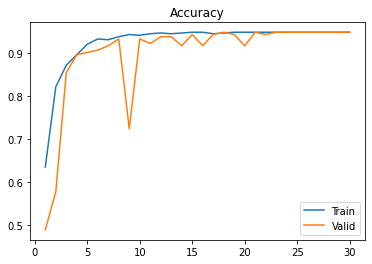

In [56]:
plt.plot(range(1, 31), history_VGG['train_acc'], label='Train')
plt.plot(range(1, 31), history_VGG['val_acc'], label='Valid')
plt.title('Accuracy')
plt.legend()
plt.show()

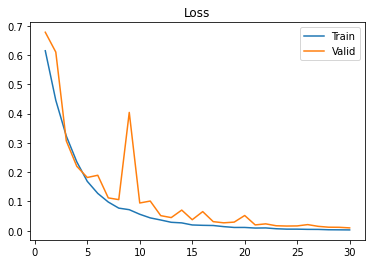

In [57]:
plt.plot(range(1, 31), history_VGG['train_loss'], label='Train')
plt.plot(range(1, 31), history_VGG['val_loss'], label='Valid')
plt.title('Loss')
plt.legend()
plt.show()

###VGG Model Selective Un-Freeze
This allows for the model to adjust gradients for the later layers of the network.  Because more general, transferrable parameters define the early layers, the later layers can be adjusted to drastically improve training times and test accuracies.

In [58]:
layers_not_to_freeze = ['24', '26', '28']

for name, param in VGG_model.named_parameters():
    layer_type, layer_index = name.split('.')[0], name.split('.')[1]

    if layer_type != "classifier":
        if layer_index not in layers_not_to_freeze:
            print(f"Layer {layer_index}: {name} freezed")
            param.requires_grad = False
        else:
            print(f"Layer {layer_index}: {name} not freezed")
            param.requires_grad = True

Layer 0: features.0.weight freezed
Layer 0: features.0.bias freezed
Layer 2: features.2.weight freezed
Layer 2: features.2.bias freezed
Layer 5: features.5.weight freezed
Layer 5: features.5.bias freezed
Layer 7: features.7.weight freezed
Layer 7: features.7.bias freezed
Layer 10: features.10.weight freezed
Layer 10: features.10.bias freezed
Layer 12: features.12.weight freezed
Layer 12: features.12.bias freezed
Layer 14: features.14.weight freezed
Layer 14: features.14.bias freezed
Layer 17: features.17.weight freezed
Layer 17: features.17.bias freezed
Layer 19: features.19.weight freezed
Layer 19: features.19.bias freezed
Layer 21: features.21.weight freezed
Layer 21: features.21.bias freezed
Layer 24: features.24.weight not freezed
Layer 24: features.24.bias not freezed
Layer 26: features.26.weight not freezed
Layer 26: features.26.bias not freezed
Layer 28: features.28.weight not freezed
Layer 28: features.28.bias not freezed


In [59]:
# define out classifier
binary_classifier = nn.Sequential(
   nn.Linear(in_features=25088, out_features=2048),
   nn.ReLU(),
   nn.Linear(in_features=2048, out_features=1024),
   nn.ReLU(),
   nn.Linear(in_features=1024, out_features=512),
   nn.ReLU(),
   nn.Linear(in_features=512, out_features=1)
)

# replace model class classifier attribute:
VGG_model.classifier = binary_classifier

###Train Modified VGG-16

In [72]:
test_acc_freeze, history_freeze = train_model(VGG_model, train_data, valid_data, test_data, device, batch_size=32, epochs=30, lr=0.00001)

Training Start
Epoch:1 / 30, train loss:0.5244 train_acc:0.7795, valid loss:0.1595 valid acc:0.9167
model saved!
Epoch:2 / 30, train loss:0.0733 train_acc:0.9375, valid loss:0.0408 valid acc:0.9427
model saved!
Epoch:3 / 30, train loss:0.0236 train_acc:0.9462, valid loss:0.0238 valid acc:0.9479
model saved!
Epoch:4 / 30, train loss:0.0138 train_acc:0.9479, valid loss:0.1612 valid acc:0.8750
Epoch:5 / 30, train loss:0.1477 train_acc:0.8958, valid loss:0.0126 valid acc:0.9479
Epoch:6 / 30, train loss:0.0088 train_acc:0.9479, valid loss:0.0089 valid acc:0.9479
Epoch:7 / 30, train loss:0.0057 train_acc:0.9479, valid loss:0.0070 valid acc:0.9479
Epoch:8 / 30, train loss:0.0042 train_acc:0.9479, valid loss:0.0054 valid acc:0.9479
Epoch:9 / 30, train loss:0.0032 train_acc:0.9479, valid loss:0.0045 valid acc:0.9479
Epoch:10 / 30, train loss:0.0026 train_acc:0.9479, valid loss:0.0037 valid acc:0.9479
Epoch:11 / 30, train loss:0.0020 train_acc:0.9479, valid loss:0.0031 valid acc:0.9479
Epoch:12 

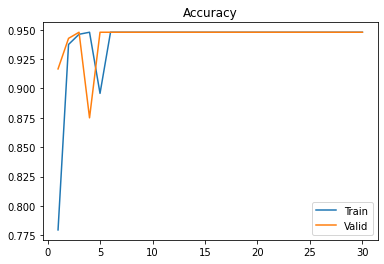

In [73]:
plt.plot(range(1, 31), history_freeze['train_acc'], label='Train')
plt.plot(range(1, 31), history_freeze['val_acc'], label='Valid')
plt.title('Accuracy')
plt.legend()
plt.show()

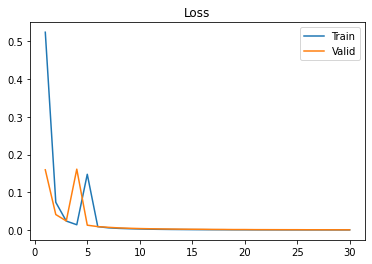

In [74]:
plt.plot(range(1, 31), history_freeze['train_loss'], label='Train')
plt.plot(range(1, 31), history_freeze['val_loss'], label='Valid')
plt.title('Loss')
plt.legend()
plt.show()